# Classification

Classification in a supervised learning task along with regression. It is used in predicting classes i.e. it is used to predict categorical data.
In this notebook the following topics will be covered: -
1. Using MNIST Dataset
2. Training a Binary Classifier
3. Performance Measures
4. Multiclass Classification
5. Error Analysis
6. Multilabel Classification
7. Multioutput Classification

## 1. Using MNIST Dataset

The dataset we will be using for classification is the MNIST dataset, which is a set of 70,000 small images of handwritten digits. Each image is labelled with the digit it represents. This dataset is often used as a way of seeing how new classification algorithms perform.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset.

In [1]:
from sklearn.datasets import fetch_openml

# Used to fetch data from openml using the name or dataset id
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit learn generally have a similar dictionary structure, including the following:
* A **DESCR** key describing the dataset
* A **data** key containing an array with one row per instance and one column per feature
* A **target** key containing an array with the labels.

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

This shows that there are 70,000 images and each image has 784 features. This is because each image has 28 * 28 pixels, and each feature represents the pixels' intensity.
To see one image we will need to plot it as if we use it normally it will only give us the numeric values.

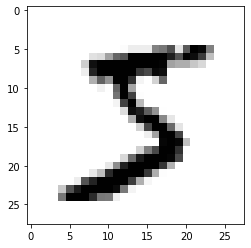

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

img = X.loc[0].to_numpy()
img = img.reshape(28, 28)
plt.imshow(img, cmap="binary")

This looks like a 5 and if we check our target it is indeed a 5

In [4]:
y[0]

'5'

We need to convert this y to an integer in the following manner

In [5]:
y = y.astype(np.uint8)
y[0]

5

Let us now just create a function that we can use to view a random image from X

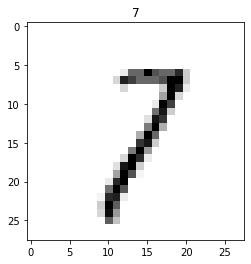

In [6]:
import random

def plot_random_digit():
    num = random.randint(0, len(X))
    random_img = X.loc[num].to_numpy()
    random_img = random_img.reshape(28, 28)
    plt.imshow(random_img, cmap="binary")
    plt.title(y[num])

plot_random_digit()

We need to now create our train and test set, MNIST already has shuffled the order for us normally this is not the case, and so we will have to do it ourselves however in this scenario we can use it directly.
Shuffling is important as some learning algorithms are sensitive to the order of training instances and will perform poorly if they get many similar training instances in a row.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
len(X_train), len(X_test)

(60000, 10000)

## 2. Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit, for example the number 4. This 4 detector is an example of binary classification, capable of distinguishing between 2 classes, 4 and not-4.
The target vector needs to first be updated.

In [10]:
# This converts all values to either True or False depending on if it is 4
y_train_4 = (y_train == 4)
y_test_4 = (y_test == 4)

Now we must choose a classifier and train it a good place tp start is with Stochastic Gradient Descent Classifier, using SciKit-Learn's **SGDClassifier** class.
This classifier has the advantage of being capable of handling large datasets very efficiently. This is in part because SGD deals with training instances independently, one at a time
(which also makes it suitable for online learning). We use it as follows: -

In [11]:
from sklearn.linear_model import SGDClassifier

# We use random state so that the results are reproducible
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(random_state=42)

The SGD classifier relies on randomness during training and hence the name "stochastic".

We can now use this model to detect images of 4.

In [15]:
img = X_train.loc[0]
sgd_clf.predict([img])

array([False])

Let us visualise this models predictions by selecting an image at random, and plotting its prediction along with the actual label

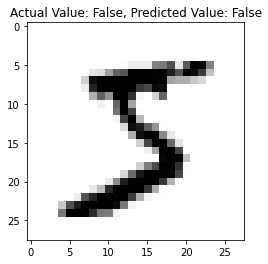

In [23]:
def plot_binary_prediction():
    num = random.randint(0, len(X))
    rand_img = X.loc[0]
    img = rand_img.to_numpy()
    img = img.reshape(28, 28)
    y_4_pred = sgd_clf.predict([rand_img])
    plt.imshow(img, cmap="binary")
    plt.title(f"Actual Value: {y_train_4[num]}, Predicted Value: {y_4_pred[0]}")

plot_binary_prediction()

## 3. Performance Measures

Evaluating a classifier is significantly trickier than evaluating a regressor.
This section will be broken up into the following subsections: -
1. Measuring accuracy using cross-validation
2. Confusion Matrix
3. Precision and Recall and the Tradeoff
4. The ROC Curve

### 3.1 Measuring accuracy using Cross-Validation

A good way to evaluate a model is to use cross-validation. Sometimes you may need to have more control over the cross validation proess than what Scikit-Learn provides. In these cases, you can implement it yourself.
The program for cross validation will be given as one of the resources in this chapter.

For now, we will use the cross_val_score() function to evaluate our **SGDClassifier** model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (3 in this case), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [24]:
from sklearn.model_selection import cross_val_score
# cv is the number of folds
cross_val_score(sgd_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.9671 , 0.97645, 0.9687 ])

The reason the accuracy is as high as it is, is because the dataset is very skewed. Most of the samples are not 4 and hence if the model always guesses not 4 ie False it will yet get a high accuracy.
To prove this lets look at a very basic classifier that predicts everything in the not-4 class.

In [25]:
from sklearn.base import BaseEstimator

class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_4_clf = Never4Classifier()
cross_val_score(never_4_clf, X_train, y_train_4, cv=3, scoring="accuracy")

array([0.90275, 0.9018 , 0.90335])

It has over 90% accuracy, thid is only bevause only 10% of images are 4's so if you always guess not a 4 you will still be right 90% of the time.

This shows accuracy is not the preffered performance metric for classifiers, especially when we deal with skewed datasets (i.e. datasets where some classes are more common than others)

### 3.2 Confusion Matrix

Confusion matrix is a much better way to evaluate the performance of a classifier. The concept behind it is to count the number of instances of class A that are classified as class B. For example, to know the number of times the classifier confused images of 4 with images of 3 you would look in the 4th and 3rd column of the confusion matrix.

To compute the confusion matrix first you need to have a set of predictions so that they can be compared to actual targets. You could make predictions on the test set, but lets keep it untouched for now (remember that you want to use the test set only t the end of the project, once you have a classifier that is ready to launch.
Instead, you can use the **cross_val_predict()** function.

In [26]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)

Just like the **cross_val_score()** function, **cross_val_predict()** performs K-fold cross_validation, but instead of returning the evaluation scores it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning prediction is made by a model that never saw the data during training).

Now using this we can get the confusion matrix using the **confusion_matrix()** function by passing target class and predicted class.

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4, y_train_pred)

array([[52957,  1201],
       [  554,  5288]])

Each row in a confusion matrix represents an actual class, while each column represents predicted class.

The first row considers non-4 images (negative class): of which 52957 were correctly classified as non-4 these are called true negative while remaining 1201 were incorrectly identified as 4 which is called false positive.

The second row considers images of 4 (positive class); of which 554 were wrongly classified as non-4 (false negative) and 5288 were correctly identified as 4s (true positive)

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values on its main diagonal (top left to bottom right).

The confusion matrix gives a lot of information, sometimes you may prefer a more concise metrix. An interesting one to look at is the accuracy of the positive predictions, this is called the precision of the classifier.

Precision = TP/(TP + FP) [where TP is true positive and FP is false positive]

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This however is not useful as classifier would ignore all but one positive instance. So preicison is typically used with anotber metric named recall, also called sensitivity or the true positive rate (TPR) this is the ratio of positive instances that are correctly detected by classifier.

Recall = TP/(TP + FN) [where TP is true positive and FN is false negative]